In [1]:
%%time 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import torch as T
import torch.nn as nn
import torch.nn.functional as F

device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
# device = T.device('cpu')

from warnings import filterwarnings
filterwarnings('ignore')

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
classes.extend('A B C D E F G H I J K L M N O P Q R S T U V W X Y Z'.upper().split())
classes.extend('A B C D E F G H I J K L M N O P Q R S T U V W X Y Z'.lower().split())

Wall time: 3.87 s


In [2]:
%%time
class ConvModel(nn.Module):
    def __init__(self, input_shape=(128, 128, 1), hidden_conv_size=[128,64,32,16], hidden_fc_size=[576, 288, 144, 144, 72], output_classes=62):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=hidden_conv_size[0], out_channels=hidden_conv_size[1], kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=hidden_conv_size[1], out_channels=hidden_conv_size[2], kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=hidden_conv_size[2], out_channels=hidden_conv_size[3], kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=hidden_fc_size[0], out_features=hidden_fc_size[1])
        self.fc2 = nn.Linear(in_features=hidden_fc_size[1], out_features=hidden_fc_size[2])
        self.fc3 = nn.Linear(in_features=hidden_fc_size[3], out_features=hidden_fc_size[4])
        self.fc4 = nn.Linear(in_features=hidden_fc_size[4], out_features=output_classes)
    def forward(self, X):
        X = F.relu(self.conv1)
        X = F.max_pool2d(X)
        X = F.relu(self.conv2)
        X = F.max_pool2d(X)
        X = F.relu(self.conv3)
        X = F.max_pool2d(X)

        X = X.view(-1, 16*6*6)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))

        return F.softmax(self.fc4, dim=1)
    def save_checkpoint(self, filename):
        T.save(self.state_dict(), filename)
    
    def load_checkpoint(self, filename):
        self.load_state_dict(T.load(filename))

Wall time: 0 ns


In [3]:
%%time
model = ConvModel()
model

Wall time: 6.02 ms


ConvModel(
  (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=288, bias=True)
  (fc2): Linear(in_features=288, out_features=144, bias=True)
  (fc3): Linear(in_features=144, out_features=72, bias=True)
  (fc4): Linear(in_features=72, out_features=62, bias=True)
)

In [4]:
%%time
criterion = nn.CrossEntropyLoss()
optimizer = T.optim.Adam(model.parameters(), lr=0.001)

Wall time: 992 µs


In [ ]:
%%time

X = []
y = []
l = 0
for dirpath, _, filenames in os.walk('data/'):
    if dirpath is not 'data/':
        for f in filenames:
            X.append(imread(f'{dirpath}/{f}'))
            y.append(l)
        l += 1

X_batch, y_batch = [], []
for i in range(0, len(X), batch_size:=100):
    X_batch.append(np.array(X[i:i+batch_size]))
    y_batch.append(np.array(y[i:i+batch_size]))

X_new = np.array(X_batch)
y_new = np.array(y_batch)

In [ ]:
%%time

print(len(X))
print(len(y))
print(X_new.shape)
print(y_new.shape)

In [7]:
%%time

batch_size = 100
X_batch, y_batch = [], []
for i in range(0, len(X), batch_size):
    X_batch.append(X[i:i+batch_size])
    y_batch.append(y[i:i+batch_size])

Wall time: 7.38 ms


In [7]:
%%time

X = T.tensor(X)
y = T.tensor(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_valn, y_train, y_valn = train_test_split(X_train, y_train, test_size=0.15)

model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_valn = X_valn.to(device)
y_valn = y_valn.to(device)

Wall time: 1min 6s


In [8]:
%%time

print(X_train.device)
print(y_train.device)
print(X_valn.device)
print(y_valn.device)
print(X_test.device)
print(y_test.device)

cuda:0
cuda:0
cuda:0
cuda:0
cpu
cpu
Wall time: 0 ns


In [9]:
%%time

print(X_train.shape)
print(y_train.shape)
print(X_valn.shape)
print(y_valn.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([40157, 128, 128, 1])
torch.Size([40157])
torch.Size([7087, 128, 128, 1])
torch.Size([7087])
torch.Size([15748, 128, 128, 1])
torch.Size([15748])
Wall time: 2.18 ms


In [10]:
%%time

epochs = 10
train_losses = []
val_losses = []
train_correct = []
val_correct = []

model.train()

for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    for b, (X_trn, y_trn) in zip(X_train, y_train):
        b += 1
        
        y_pred = model(X_trn)
        loss = criterion(y_pred, y_trn)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_trn).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b % 600 == 0:
            print(f"EPOCH: {i} BATCH: {b} LOSS: {loss.item()}")
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
            
    with torch.no_grad():
        for b, (X_test, y_test) in zip(X_valn, y_valn):

            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1]
            tst_corr = (predicted == y_test).sum()
                
    loss = criterion(y_val, y_test)
    val_losses.append(loss)
    val_correct.append(tst_corr)

TypeError: iteration over a 0-d tensor

Wall time: 100 ms


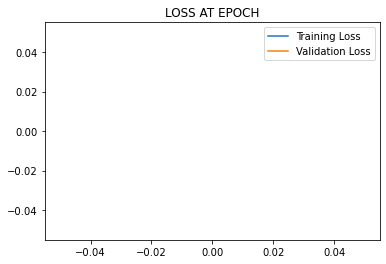

In [11]:
%%time

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('LOSS AT EPOCH')
plt.legend()